In [1]:
import cv2 as cv
import matplotlib.pyplot as pt

In [2]:
n= cv.dnn.readNetFromTensorflow("graph_opt.pb")

In [3]:
iw = 368
ih= 368
ct =0.2



In [4]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]


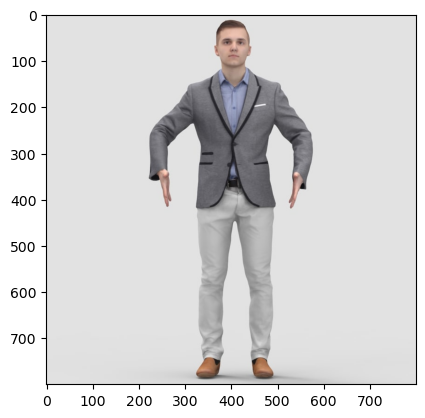

In [5]:
image=cv.imread("image.jpg")
pt.imshow(cv.cvtColor(image,cv.COLOR_BGR2RGB))

In [6]:
def ps(f):
    fw=f.shape[1]
    fh=f.shape[0]
    n.setInput(cv.dnn.blobFromImage(f,1.0,(iw,ih),(127.5,127.5,127.5),swapRB=True,crop=False))
    out = n.forward()
    out = out[:, :19, :, :]  
    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        
        heatMap = out[0, i, :, :]

        
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (fw * point[0]) / out.shape[3]
        y = (fh * point[1]) / out.shape[2]
        
        points.append((int(x), int(y)) if conf > ct else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(f, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(f, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(f, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = n.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(f, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return f

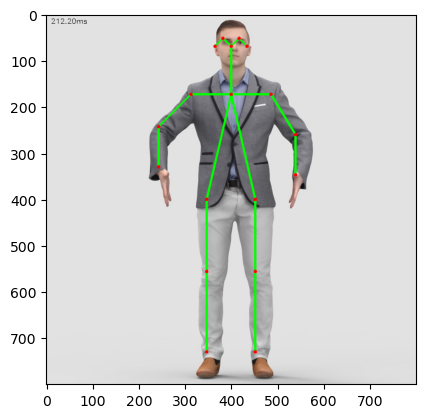

In [7]:
ei = ps(image)
pt.imshow(cv.cvtColor(image,cv.COLOR_BGR2RGB))

In [9]:
capture=cv.VideoCapture('')
capture.set(3,800)
capture.set(4,800)
if not capture.isOpened():
    cap=cv2.VideoCapture(0)    
if not capture.isOpened():
   raise IOError("hello")
while True:
    h,f=capture.read()
    if not h:
        cv.waitKey()
        break
    fw=f.shape[1]
    fh=f.shape[0]
    n.setInput(cv.dnn.blobFromImage(f,1.0,(iw,ih),(127.5,127.5,127.5),swapRB=True,crop=False))
    out = n.forward()
    out = out[:, :19, :, :]  
    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (fw * point[0]) / out.shape[3]
        y = (fh * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > ct else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(f, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(f, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(f, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = n.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(f, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    cv.imshow('human pose estimaition',f)  
    if cv.waitKey(5) & 0xff == ord('q'):
        break
cv.destroyAllWindows()   
capture.release()

        